# Predictiong and Analysis of Inflation

Hi,

My name is Leon, and this is my Analysis of inflation project.

In the project below I am going to analyze relationship between different inflation metrics, as well as predict price inflation.  

In the older days, the definition of inflation was increase of monetary supply, which devalues the currency.  
However in modern days by inflation what is meant usually in increase in prices, which also means devaluation of the currency, but in a different way.  

For the monetary supply index I will use M1 for this notebook.  
For the price index I will use CPI index,

In the nootebook below I am going to analyze the relationship between M1 and CPI as well as those indices individually.  

The final goal of the notebook is to build a model to predict CPI inflation index by data including the M1.

## Data description

### Monetary supply

There are various indices for measuring how much money exists in the economy:  
M0, M1, M2, M3, M4  
Basically the difference between them is what is considered as money in the index and what is not,  
For example M0 index is used to measure the amount of all banknotes and coins, and M1 adds checkable deposits (a type of credit) on top of that.  
each subsequent index includes more asset classes on top of what the previous one includes.  
More information on the indices:  
https://www.wallstreetmojo.com/money-supply/

All the data is available on the [Federal Reserve website](https://fred.stlouisfed.org/).  
We'll use the following dataset as it is not adjusted to inflation:  
https://fred.stlouisfed.org/series/M1NS 

### Prices increases

For the data for increases in prices we'll choose CPI (Consumer Price Index),  
It is calculated by the [U.S. BUREAU OF LABOR STATISTICS](https://www.bls.gov/).  
In short, it measures the cost of various specific goods that are consumed by everyday people.
Although this index is far from perfect for many reasons,  
It is still the most common index of prices inflation.  
More information on the CPI and how it is measured:  
https://www.investopedia.com/terms/c/consumerpriceindex.asp   

The data can be downloaded from the BLS website:  
https://www.bls.gov/cpi/data.htm

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from datetime import datetime

# Model packages
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv

# preprocessing libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.utils import resample
from numpy.random import RandomState
import warnings
from IPython.display import clear_output


# Evaluation
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import roc_auc_score


# from keras.optimizers import RMSprop

from random import seed
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.ticker as mtick

## Loading datasets

The data is very small, as each dataset consists of just a single datapoint for every month for several decades.  
So all the data was already downloaded and saved locally to small excel files in this repository.

### CPI

Source: [BLS](https://data.bls.gov/PDQWeb/ap)

In [3]:
df_cpi_raw = pd.read_excel('cpi data.xlsx', skiprows=11)

In [4]:
df_cpi_raw.sample(3)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
80,1993.0,142.6,143.1,143.6,144.0,144.2,144.4,144.4,144.8,145.1,145.7,145.8,145.8,143.7,145.3
90,2003.0,181.7,183.1,184.2,183.8,183.5,183.7,183.9,184.6,185.2,185.0,184.5,184.3,183.3,184.6
32,1945.0,17.8,17.8,17.8,17.8,17.9,18.1,18.1,18.1,18.1,18.1,18.1,18.2,NaN,NaN


### M1

In [5]:
df_m1_raw = pd.read_excel('M1NS.xls', skiprows=10)

In [6]:
df_m1_raw.sample(3)

,observation_date,M1NS
301,1984-02-01,516.9
199,1975-08-01,282.7
756,2022-01-01,20549.4


### M2

In [7]:
df_m2_raw = pd.read_excel('M2NS.xls', skiprows=10)

In [8]:
df_m2_raw.sample(3)

,observation_date,M2NS
306,1984-07-01,2228.0
371,1989-12-01,3165.6
211,1976-08-01,1097.3


Looks like M1 and M2 data dataset are already stored in convenient Time Series format,  
But We'll need to transform the CPI data to match the other datasets.

## Checking Data integrity

### CPI

In [9]:
df_cpi_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    110 non-null    float64
 1   Jan     110 non-null    float64
 2   Feb     110 non-null    float64
 3   Mar     110 non-null    float64
 4   Apr     110 non-null    float64
 5   May     110 non-null    float64
 6   Jun     110 non-null    float64
 7   Jul     110 non-null    float64
 8   Aug     110 non-null    float64
 9   Sep     109 non-null    float64
 10  Oct     109 non-null    float64
 11  Nov     109 non-null    float64
 12  Dec     109 non-null    float64
 13  HALF1   39 non-null     float64
 14  HALF2   38 non-null     float64
dtypes: float64(15)
memory usage: 13.0 KB


In [10]:
df_cpi_raw.head(5)

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
0,1913.0,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,NaN,NaN
1,1914.0,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,NaN,NaN
2,1915.0,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,NaN,NaN
3,1916.0,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,NaN,NaN
4,1917.0,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,NaN,NaN


We see 2 definetely excess columns here: HALF1, HALF2.  
Better get rid of them now.

In [11]:
df_cpi_raw = df_cpi_raw.drop(["HALF1", "HALF2"], axis=1)

### M1

In [12]:
df_m1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   observation_date  764 non-null    datetime64[ns]
 1   M1NS              764 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.1 KB


In [13]:
df_m1_raw.head(10)

,observation_date,M1NS
0,1959-01-01,142.2
1,1959-02-01,139.3
2,1959-03-01,138.4
3,1959-04-01,139.7
4,1959-05-01,138.7
5,1959-06-01,139.4
6,1959-07-01,140.3
7,1959-08-01,140.0
8,1959-09-01,140.3
9,1959-10-01,140.7


In [14]:
df_m1_raw.shape

(764, 2)

The data here is already in the format I want to be, so there won't be much of data transformation on this dataframe.

In [15]:
df_m1_raw = df_m1_raw.rename(columns={
    'observation_date' : 'month',
    'M1NS' : 'M1'})

In [16]:
df_m2_raw.sample(3)

,observation_date,M2NS
357,1988-10-01,2962.0
706,2017-11-01,13819.9
722,2019-03-01,14572.5


In [17]:
df_m2_raw = df_m2_raw.rename(columns={
    'observation_date' : 'month',
    'M2NS' : 'M2'})

## Preprocessing

We'll join data from all the datasets into a single dataframe called df_inflation

In [18]:
df_inflation = df_m1_raw.copy()

In [19]:
df_inflation.sample(5)

,month,M1
564,2006-01-01,1375.5
191,1974-12-01,281.8
681,2015-10-01,3011.9
236,1978-09-01,352.7
625,2011-02-01,1858.7


Let's transform the CPI dataframe to the same format as the M1 dataframe

In [20]:
df_cpi_raw = df_cpi_raw.melt(id_vars=["Year"]).sort_values(by="Year")

In [21]:
df_cpi_raw.head(15)

,Year,variable,value
0,1913.0,Jan,9.8
330,1913.0,Apr,9.8
550,1913.0,Jun,9.8
660,1913.0,Jul,9.9
220,1913.0,Mar,9.8
770,1913.0,Aug,9.9
1210,1913.0,Dec,10.0
880,1913.0,Sep,10.0
110,1913.0,Feb,9.8
990,1913.0,Oct,10.0


I'll just rename month to a normal feature name,
I call it **month_raw** as I want to use month afterwards for the full month format

In [22]:
df_cpi_raw = df_cpi_raw.rename(columns={
    'variable' : 'month_raw',
    'value' : 'CPI'})

In [23]:
df_cpi_raw.head(15)

,Year,month_raw,CPI
0,1913.0,Jan,9.8
330,1913.0,Apr,9.8
550,1913.0,Jun,9.8
660,1913.0,Jul,9.9
220,1913.0,Mar,9.8
770,1913.0,Aug,9.9
1210,1913.0,Dec,10.0
880,1913.0,Sep,10.0
110,1913.0,Feb,9.8
990,1913.0,Oct,10.0


In [24]:
df_cpi_raw['Year'] = df_cpi_raw['Year'].astype('int')

In [25]:
df_cpi_raw['month'] = pd.to_datetime(df_cpi_raw['month_raw'] + ' ' + df_cpi_raw['Year'].astype('str'))

In [26]:
df_cpi_raw = df_cpi_raw.sort_values(by='month')

In [27]:
df_inflation = df_inflation.merge(df_cpi_raw, on="month", how="outer")

In [28]:
df_inflation = df_inflation.merge(df_m2_raw, on="month", how="outer")

In [29]:
df_inflation

,month,M1,Year,month_raw,CPI,M2
0,1959-01-01,142.2,1959,Jan,29.0,289.8
1,1959-02-01,139.3,1959,Feb,28.9,287.7
2,1959-03-01,138.4,1959,Mar,28.9,287.9
3,1959-04-01,139.7,1959,Apr,29.0,290.2
4,1959-05-01,138.7,1959,May,29.0,290.2
...,...,...,...,...,...,...
1315,1958-12-01,NaN,1958,Dec,28.9,NaN
1316,2022-09-01,NaN,2022,Sep,NaN,NaN
1317,2022-10-01,NaN,2022,Oct,NaN,NaN
1318,2022-11-01,NaN,2022,Nov,NaN,NaN


In [30]:
df_inflation = df_inflation.sort_values(by='month').reset_index(drop=True)

In [31]:
def add_pct_change_and_sma_per_timeframe_to_df(period_name, period_length):
    df_inflation['cpi_' + period_name + '_change'] = df_inflation['CPI'].pct_change(periods=period_length)
    df_inflation['m1_' + period_name + '_change'] = df_inflation['M1'].pct_change(period_length)
    df_inflation['m2_' + period_name + '_change'] = df_inflation['M2'].pct_change(period_length)
    df_inflation['cpi_' + period_name + '_sma'] = df_inflation['cpi_' + period_name + '_change'].dropna().rolling(15).mean()
    df_inflation['m1_' + period_name + '_sma'] = df_inflation['m1_' + period_name + '_change'].dropna().rolling(15).mean()
    df_inflation['m2_' + period_name + '_sma'] = df_inflation['m2_' + period_name + '_change'].dropna().rolling(15).mean()

In [32]:
add_pct_change_and_sma_per_timeframe_to_df('monthly', 1)

In [33]:
add_pct_change_and_sma_per_timeframe_to_df('quarterly', 3)

In [34]:
add_pct_change_and_sma_per_timeframe_to_df('half_year', 6)

In [35]:
add_pct_change_and_sma_per_timeframe_to_df('yearly', 12)

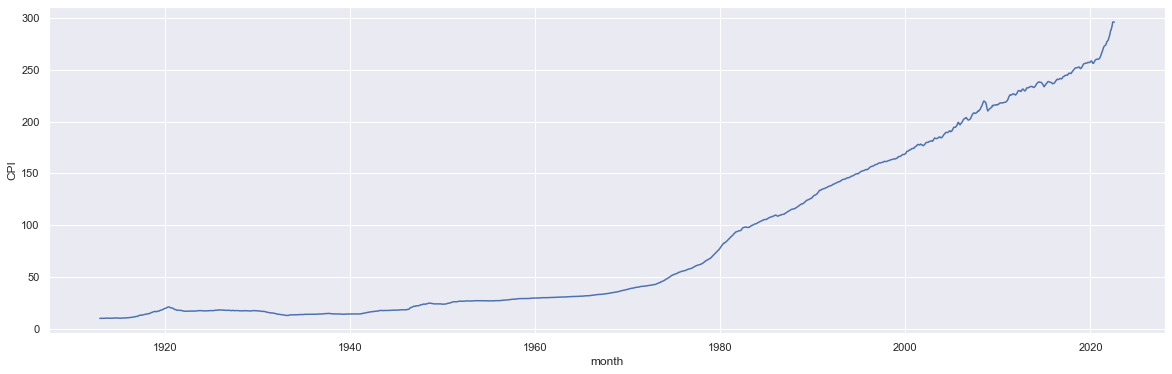

In [36]:
sns.set(rc = {'figure.figsize':(20,6)})
sns.lineplot(data=df_inflation, x="month", y="CPI")
plt.show()

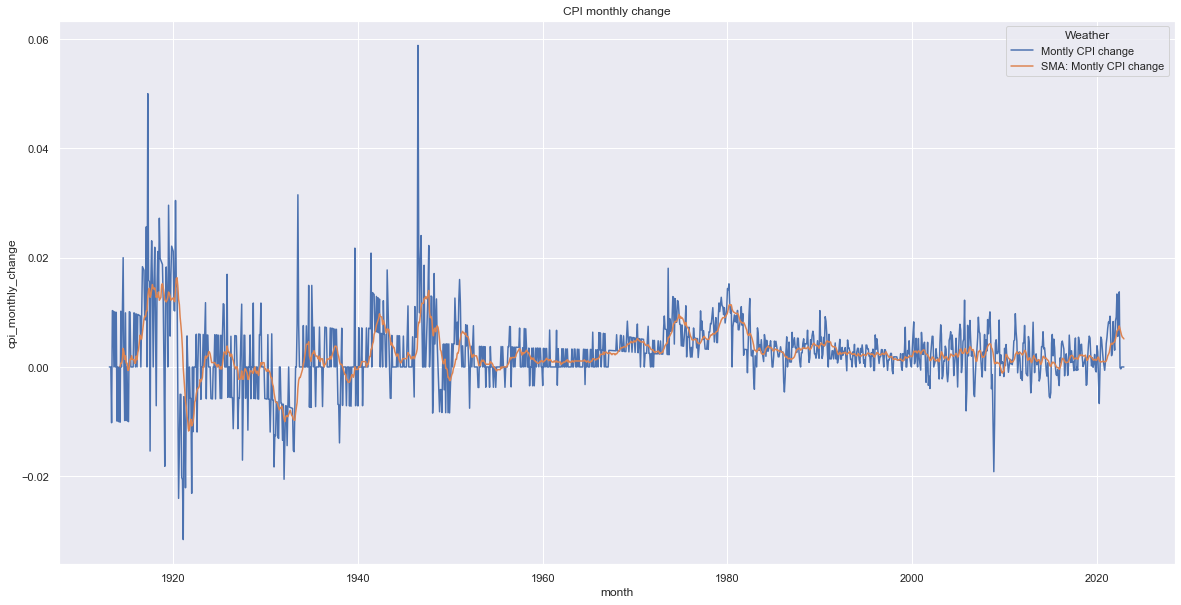

In [37]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, axes = plt.subplots(1, 1)
ax=axes
sns.lineplot(data=df_inflation, x="month", y="cpi_monthly_change", ax=ax, legend='auto')
sns.lineplot(data=df_inflation, x="month", y="cpi_monthly_sma", ax=ax, legend='auto')
ax.set(title="CPI monthly change")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(labels=["Montly CPI change","SMA: Montly CPI change"], title = "Weather")
plt.show()

The data looks very noisy amd it looks like the seasonality is way different in the 60th than in the last 3 decades.  
Also there are many differences in monetary concepts between now and then.  
I think it would be wiser to look at a shorter timeframe, say let's take a look at the data starting from 1996, so it's approximately 2.5 decades before today

In [38]:
df_inflation_last_decades = df_inflation.query('month > "Jan 1994"')

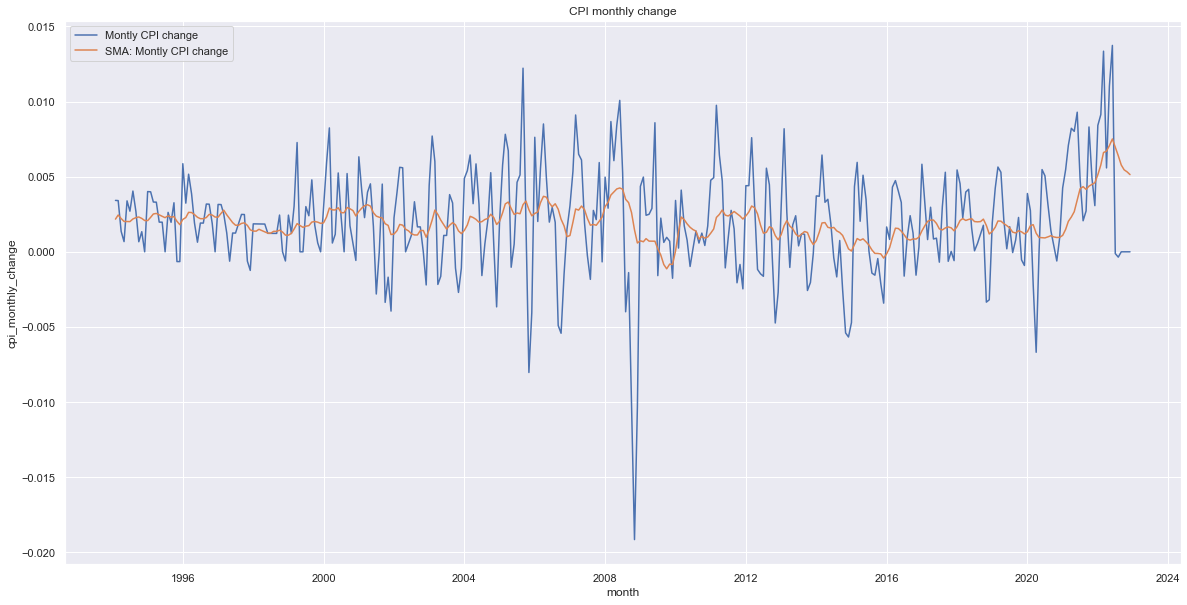

In [39]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, axes = plt.subplots(1, 1)
ax=axes
sns.lineplot(data=df_inflation_last_decades, x="month", y="cpi_monthly_change", ax=ax, legend='auto')
sns.lineplot(data=df_inflation_last_decades, x="month", y="cpi_monthly_sma", ax=ax, legend='auto')
ax.set(title="CPI monthly change")
# ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(labels=["Montly CPI change","SMA: Montly CPI change"])
plt.show()

## EDA

### CPI

In [40]:
def plot_pct_changes_of_inflation(df, period_name, metric):
    sns.set(rc = {'figure.figsize':(20,6)})
    fig, axes = plt.subplots(1, 1)
    ax=axes
    sns.lineplot(data=df, x="month", y=metric + "_" + period_name + "_change", ax=ax, legend='auto')
    sns.lineplot(data=df, x="month", y=metric + "_" + period_name + "_sma", ax=ax, legend='auto')
    ax.set(title=metric.upper() + " " + period_name + " change")
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend(labels=[period_name.capitalize() + " " + metric.upper() +
                       " change","SMA: " + period_name.capitalize() + " " + metric.upper() +" change"])
    plt.show()

In [41]:
list_periods = ['monthly', 
                'quarterly', 
                'half_year', 
                'yearly']

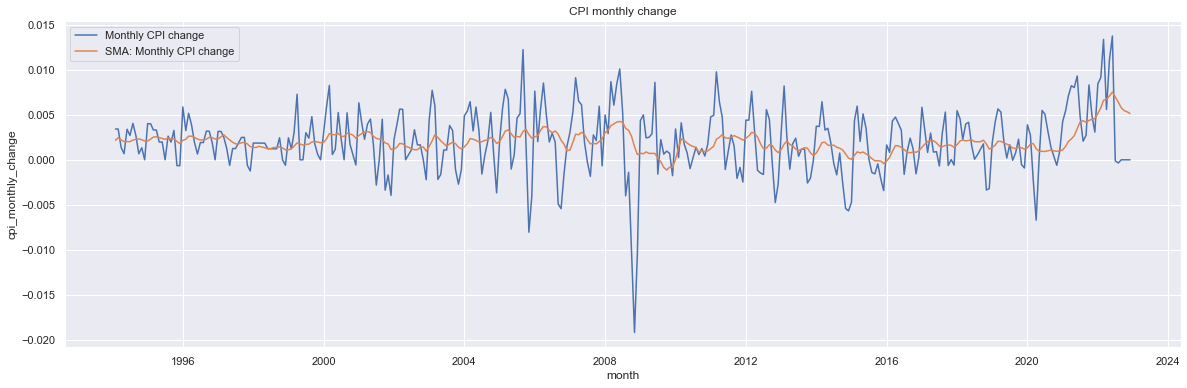

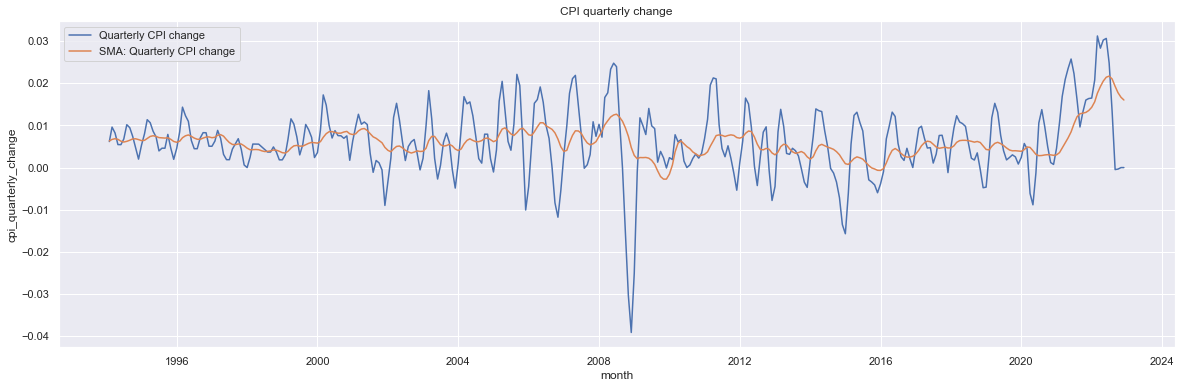

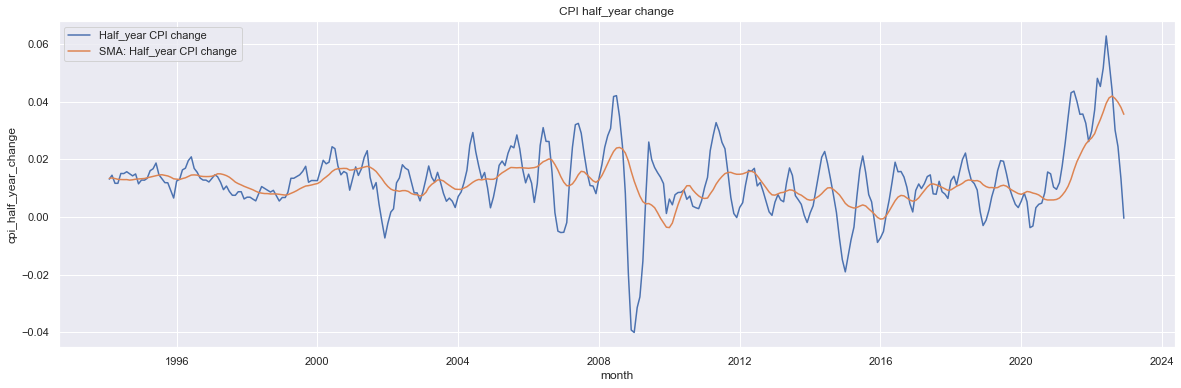

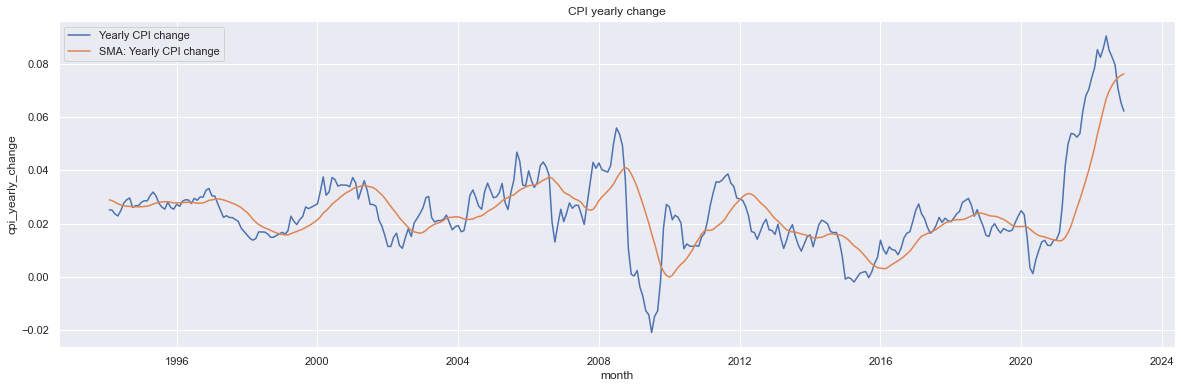

In [42]:
for p in list_periods:
    plot_pct_changes_of_inflation(df_inflation_last_decades, p, 'cpi')

### M1

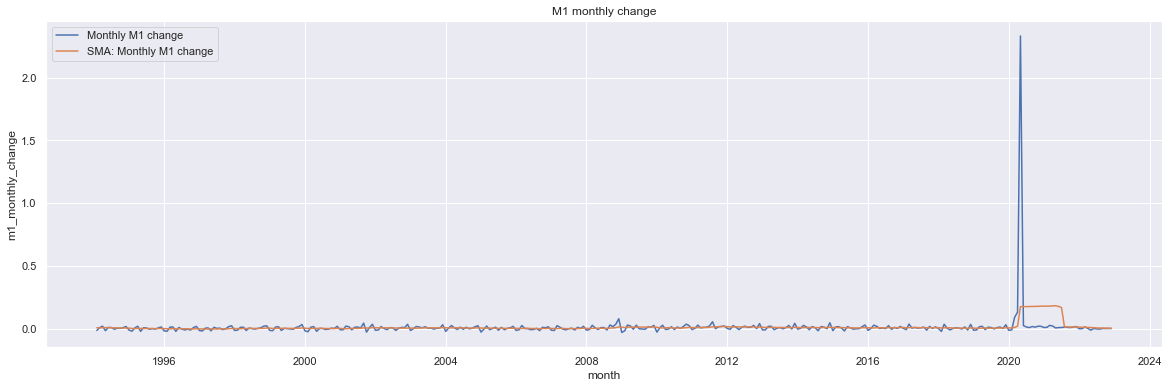

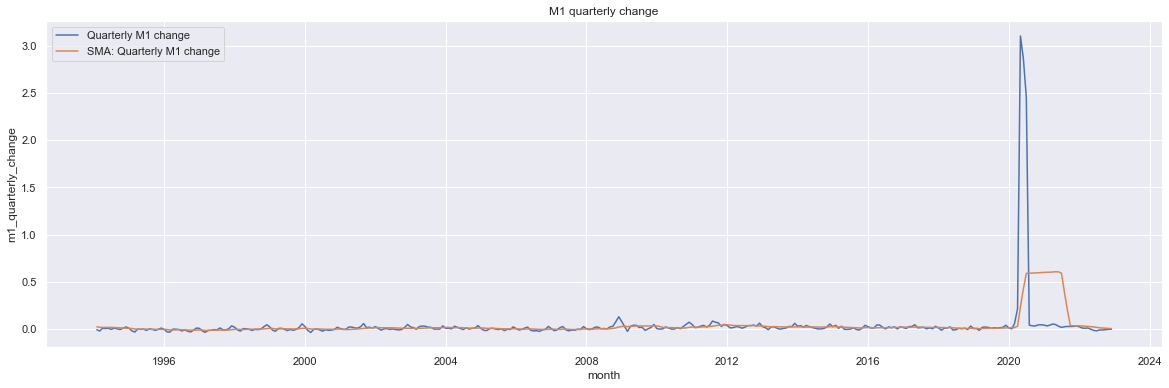

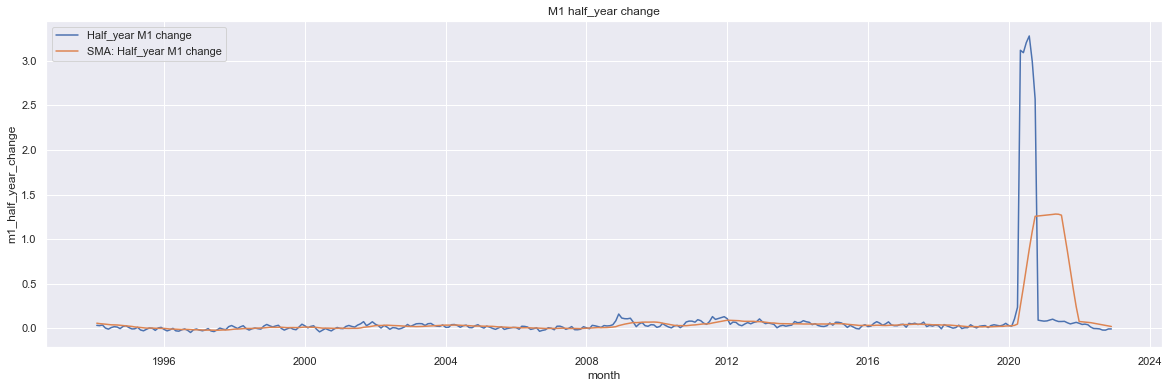

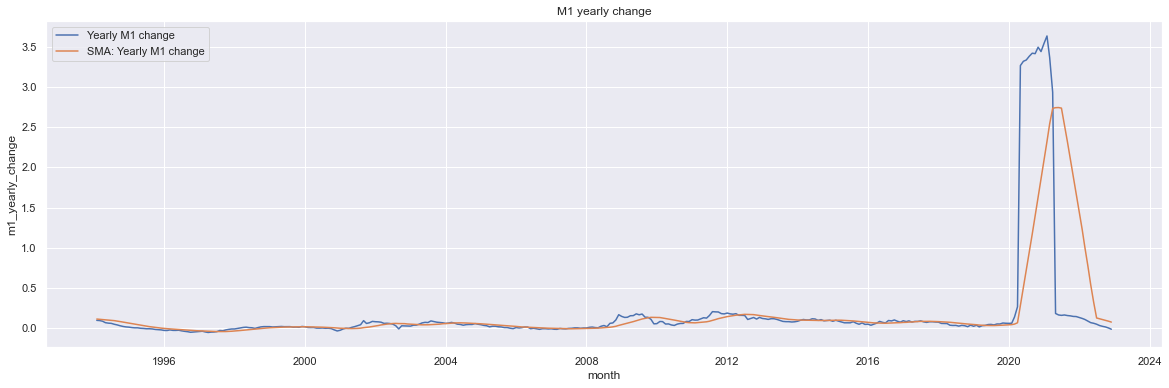

In [43]:
for p in list_periods:
    plot_pct_changes_of_inflation(df_inflation_last_decades, p, 'm1')

### M2

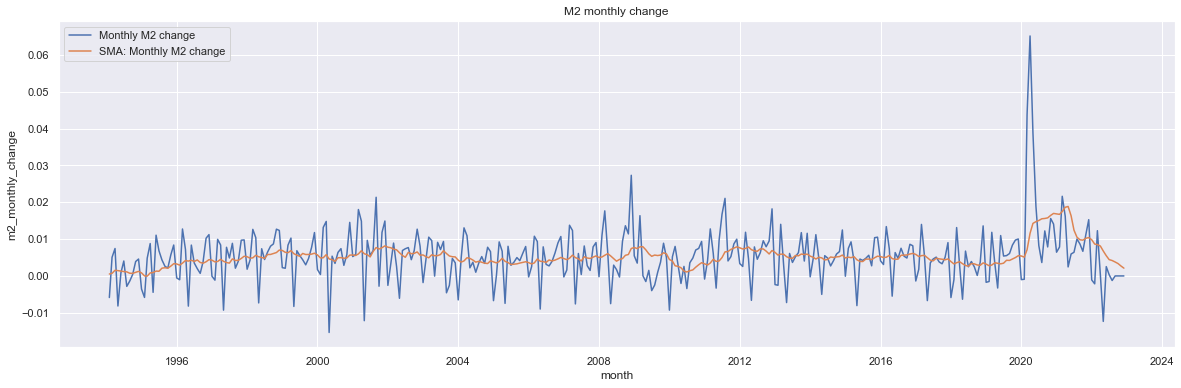

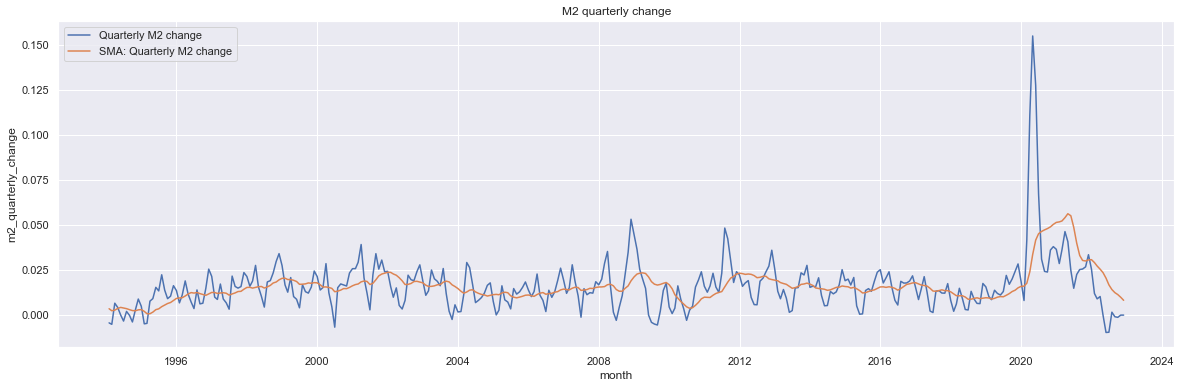

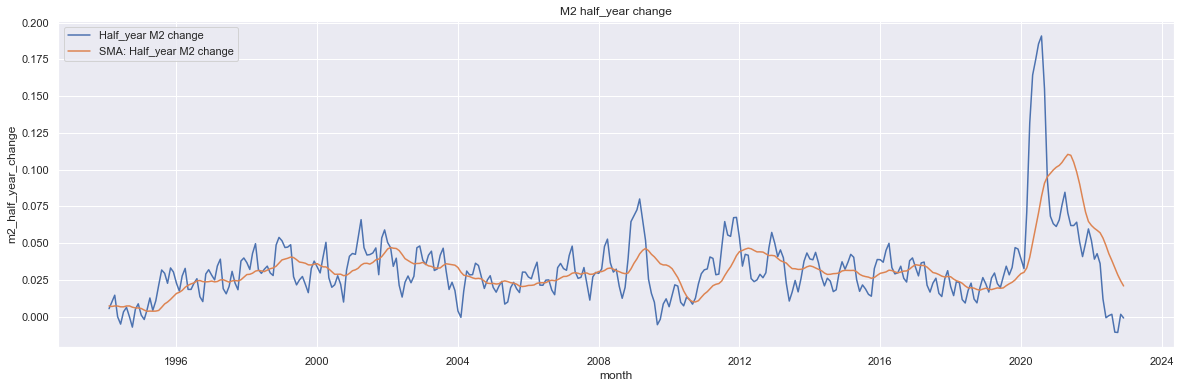

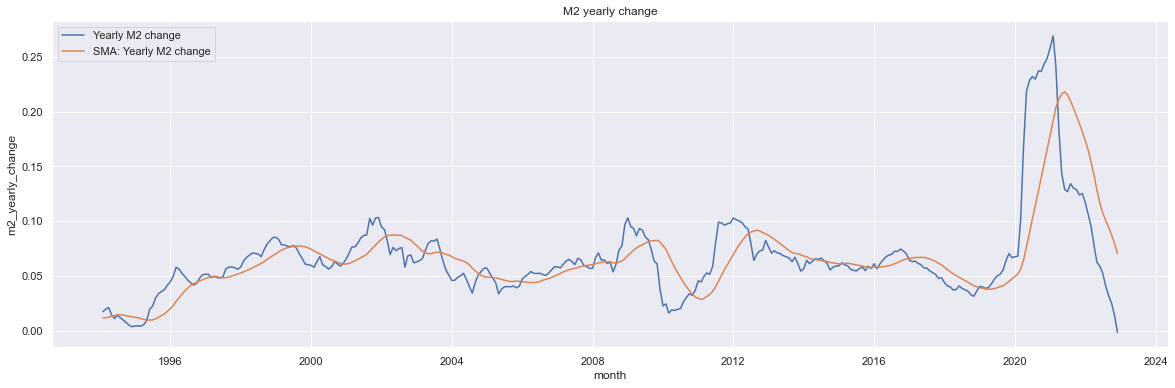

In [44]:
for p in list_periods:
    plot_pct_changes_of_inflation(df_inflation_last_decades, p, 'm2')

### Distribution

Now after we looked at the change as a line plot, lets also see the distributions of inflation change

In [45]:
df_inflation_last_decades

,month,M1,Year,month_raw,CPI,M2,cpi_monthly_change,m1_monthly_change,m2_monthly_change,cpi_monthly_sma,...,m2_half_year_change,cpi_half_year_sma,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma
973,1994-02-01,1123.8,1994,Feb,146.700,3459.7,0.003420,-0.015678,-0.005862,0.002174,...,0.005464,0.013381,0.056926,0.007299,0.025157,0.099716,0.017349,0.028922,0.116059,0.011584
974,1994-03-01,1131.1,1994,Mar,147.200,3477.2,0.003408,0.006496,0.005058,0.002449,...,0.009787,0.013538,0.052254,0.006917,0.025070,0.097623,0.019557,0.028660,0.113102,0.011807
975,1994-04-01,1152.2,1994,Apr,147.400,3503.1,0.001359,0.018654,0.007449,0.002210,...,0.014597,0.013319,0.049297,0.007293,0.023611,0.089654,0.021193,0.028062,0.110102,0.012424
976,1994-05-01,1132.0,1994,May,147.500,3474.5,0.000678,-0.017532,-0.008164,0.002022,...,-0.000058,0.013056,0.045915,0.007206,0.022885,0.071158,0.014453,0.027423,0.107065,0.013179
977,1994-06-01,1141.8,1994,Jun,148.000,3477.4,0.003390,0.008657,0.000835,0.002015,...,-0.005064,0.012976,0.042007,0.006686,0.024931,0.065311,0.011019,0.027027,0.104183,0.013802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1315,2022-08-01,20380.2,2022,Aug,296.171,21625.3,-0.000354,-0.004470,-0.001247,0.006396,...,0.001612,0.041952,0.043250,0.038186,0.082627,0.035385,0.040779,0.072031,0.119461,0.100705
1316,2022-09-01,NaN,2022,Sep,NaN,NaN,0.000000,0.000000,0.000000,0.005777,...,-0.010546,0.041090,0.036847,0.033352,0.079695,0.025460,0.031845,0.073750,0.110013,0.094222
1317,2022-10-01,NaN,2022,Oct,NaN,NaN,0.000000,0.000000,0.000000,0.005456,...,-0.010750,0.039807,0.030379,0.028505,0.070798,0.017941,0.024993,0.074893,0.100409,0.087417
1318,2022-11-01,NaN,2022,Nov,NaN,NaN,0.000000,0.000000,0.000000,0.005319,...,0.001616,0.038016,0.024683,0.024331,0.065563,0.005566,0.013626,0.075763,0.089657,0.079378


<AxesSubplot:xlabel='cpi_monthly_change', ylabel='Density'>

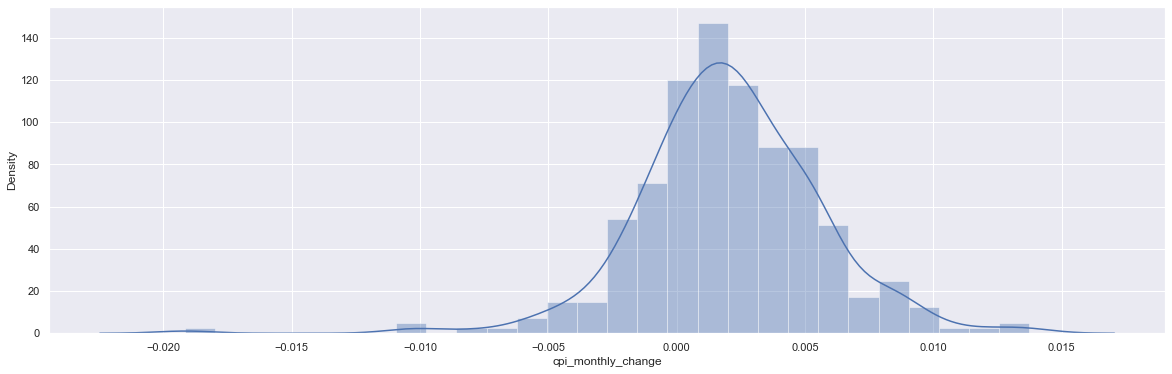

In [46]:
sns.distplot(df_inflation_last_decades['cpi_monthly_change'])

<AxesSubplot:xlabel='cpi_yearly_change', ylabel='Density'>

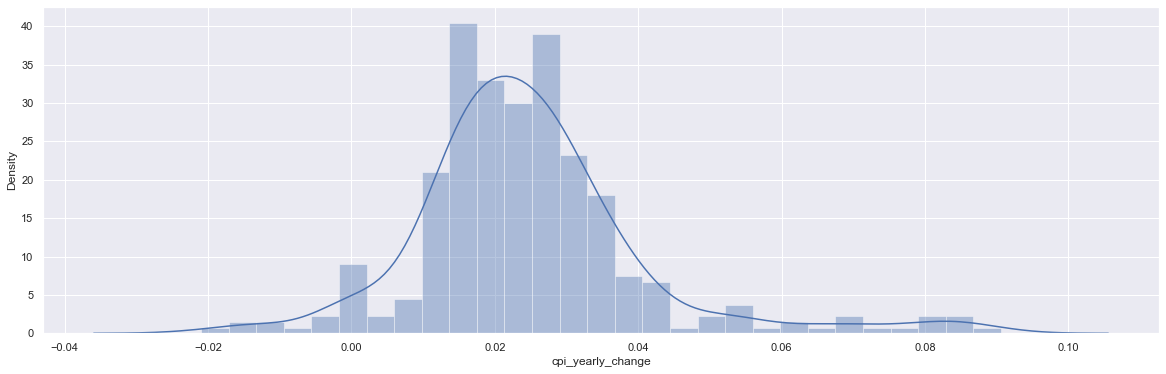

In [47]:
sns.distplot(df_inflation_last_decades['cpi_yearly_change'])

In [48]:
df_inflation_last_decades['cpi_yearly_change'].describe()

count    347.000000
mean       0.024714
std        0.016070
min       -0.020972
25%        0.016244
50%        0.022769
75%        0.030138
max        0.090598
Name: cpi_yearly_change, dtype: float64

In [49]:
(1+df_inflation_last_decades['cpi_yearly_change'].mean())**20

1.6294989263230897

#### Monthly breakdown

In [50]:
months_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

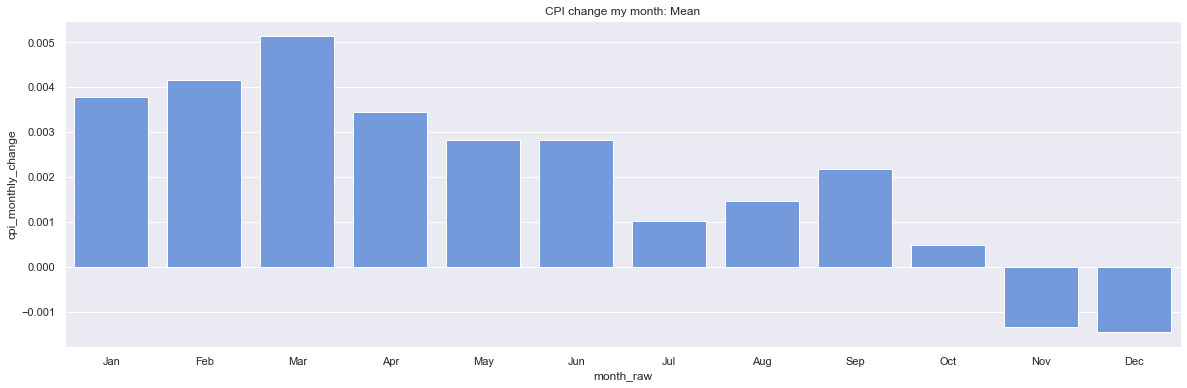

In [51]:
df_temp = df_inflation_last_decades.groupby('month_raw').agg({"cpi_monthly_change" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
ax = sns.barplot(data=df_temp, x='month_raw', y='cpi_monthly_change', color='cornflowerblue')
ax.set(title='CPI change my month: Mean')
plt.show()

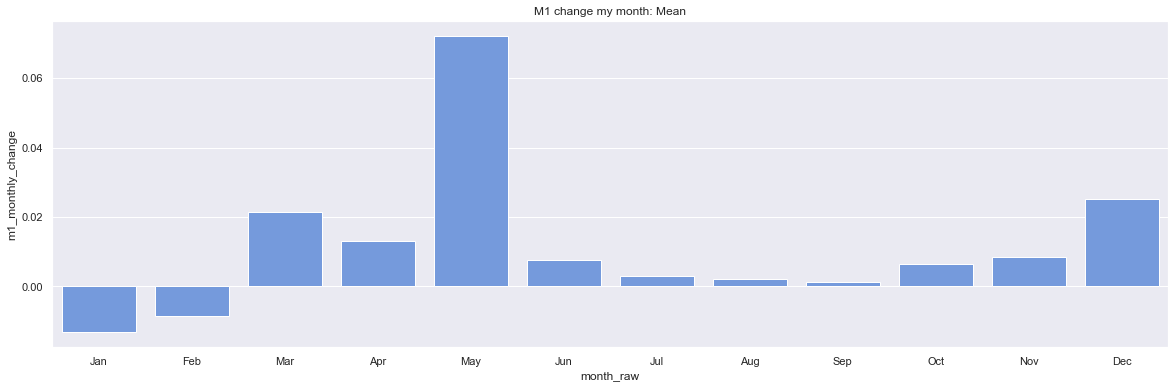

In [52]:
df_temp = df_inflation_last_decades.groupby('month_raw').agg({"m1_monthly_change" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
ax = sns.barplot(data=df_temp, x='month_raw', y='m1_monthly_change', color='cornflowerblue')
ax.set(title='M1 change my month: Mean')
plt.show()

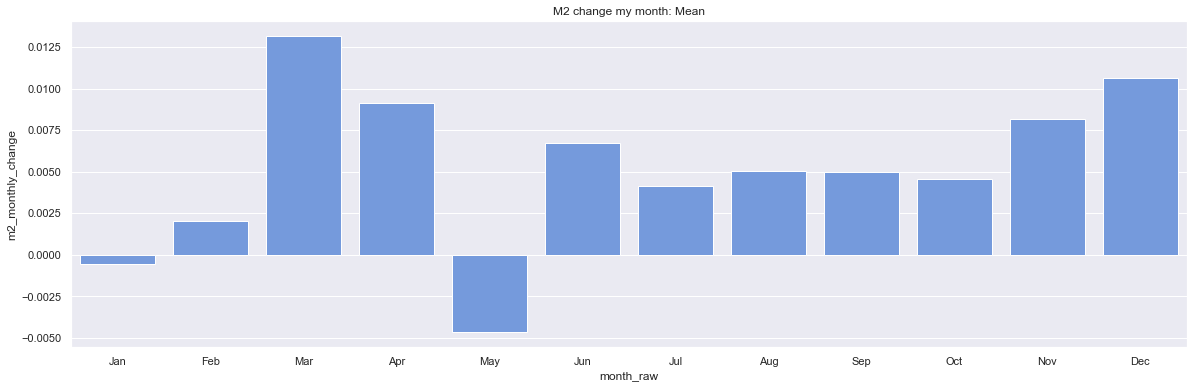

In [53]:
df_temp = df_inflation_last_decades.groupby('month_raw').agg({"m2_monthly_change" : "mean"}).reset_index()#.plot(kind='bar')
df_temp['month_raw'] = pd.Categorical(df_temp['month_raw'], categories=months_names, ordered=True)
df_temp = df_temp.sort_values(by='month_raw')
ax = sns.barplot(data=df_temp, x='month_raw', y='m2_monthly_change', color='cornflowerblue')
ax.set(title='M2 change my month: Mean')
plt.show()

In [54]:
df_temp

,month_raw,m2_monthly_change
4,Jan,-0.000571
3,Feb,0.002057
7,Mar,0.013182
0,Apr,0.009162
8,May,-0.004670
6,Jun,0.006726
5,Jul,0.004164
1,Aug,0.005068
11,Sep,0.004976
10,Oct,0.004576


### relationship between the inflation metrics

Now let's divide out dataset to train and test, and then continue analyzing just the train set to avoid target leakage on the model engineering process

In [55]:
df_inflation_time_train = df_inflation.query('month >= "Jan 1994" and month <= "Jan 2012"')

Now let's explore graphically the relation between CPI and M1 change.  
As the pct_change data is very noisy by it's nature,  
I'll compare the Simple Moving Average of both metrics.

In [56]:
def plot_pct_change_sma_of_2_features(df, feature1, feature2, title=None,
                                      feature1_column=None, feature2_column=None):
    feature1_column = feature1 + '_yearly_sma' if feature1_column is None else feature1_column
    feature2_column = feature2 + '_yearly_sma' if feature2_column is None else feature2_column
    title = feature1.upper() + " and " + feature2.upper() + " change (SMA) side by side" if title is None else title
    sns.set(rc = {'figure.figsize':(20,10)})
    fig, axes = plt.subplots(1, 1)
    ax=axes
    sns.lineplot(data=df, x="month", y=feature1_column)
    sns.lineplot(data=df, x="month", y=feature2_column)
    ax.set(title=title)
    plt.legend(labels=[feature1.upper() , feature2.upper()])
    plt.show()

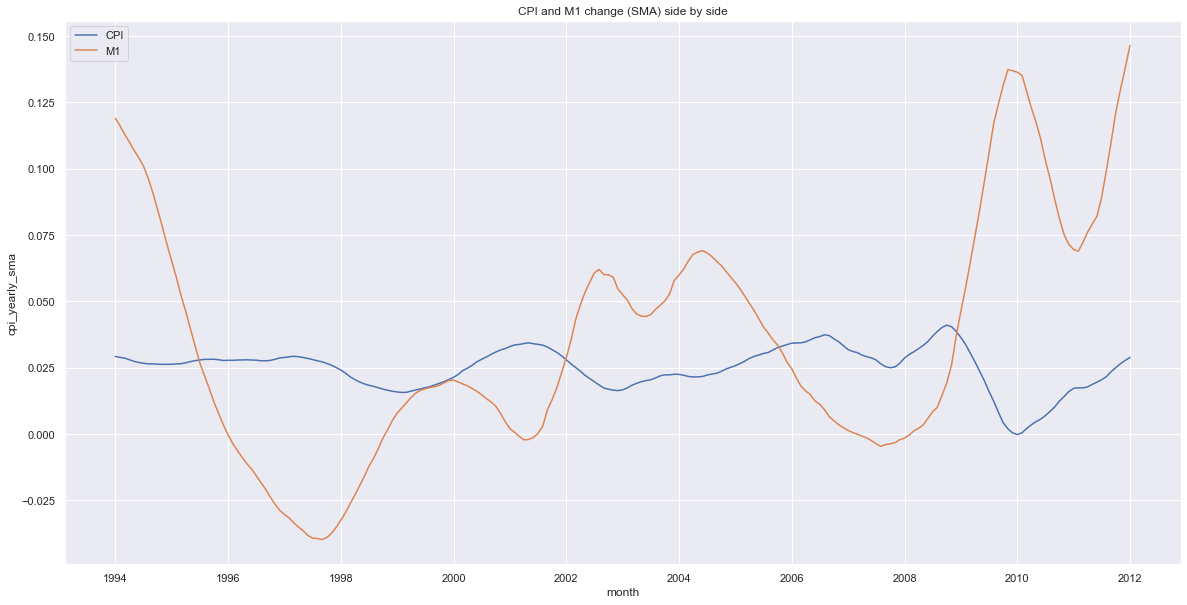

In [57]:
plot_pct_change_sma_of_2_features(df_inflation_time_train, 'cpi', 'm1')

If we look closely we may see that is several instances the trend of the CPI follows the trend of M1 with a 2 year lag.  
Let's take a closer look by plotting a lagged version of M1.

let's extract the 2 year lag feature and add it to our df

In [58]:
df_inflation_time_train['m1_yearly_change_shift'] = df_inflation_time_train['m1_yearly_change'].shift(24) * 0.2
df_inflation_time_train['m1_yearly_sma_shift'] = df_inflation_time_train['m1_yearly_sma'].shift(24)*0.25

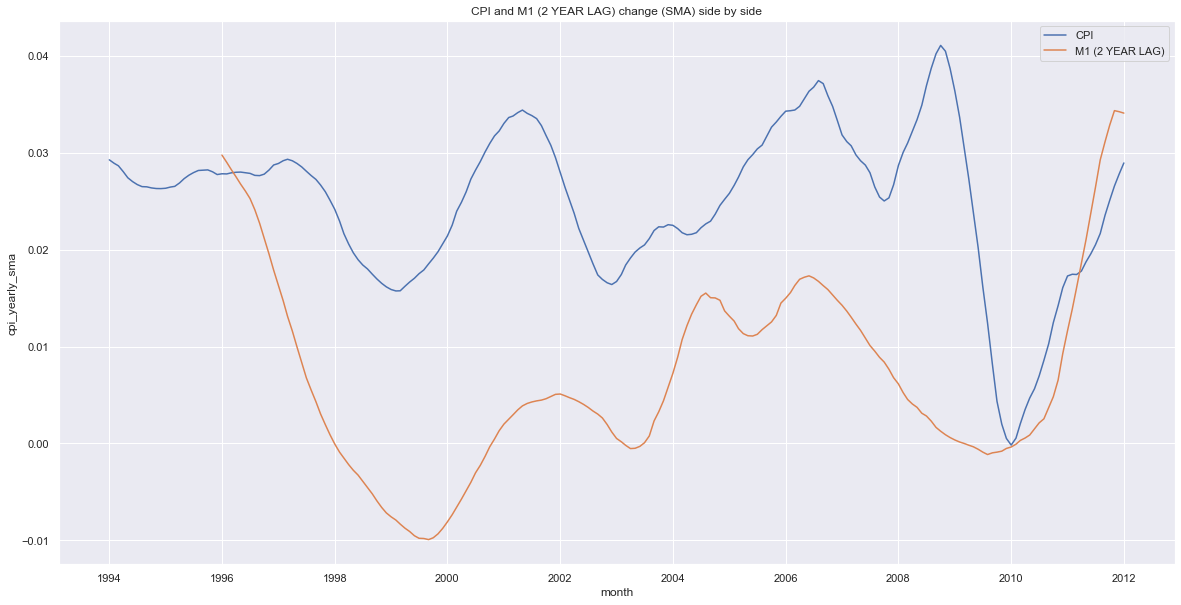

In [59]:
plot_pct_change_sma_of_2_features(df_inflation_time_train, 'cpi', 'm1 (2 year lag)', feature2_column='m1_yearly_sma_shift')

We can see visually that change in CPI is strongly correlated to change in M1 two years prior

Let's see the actual pearson correlation

In [60]:
df_inflation_time_train.corr()['cpi_yearly_sma']['m1_yearly_sma_shift']

0.33359907636433056

While linearry the correlation is weaker than expected, graphically we see heavy correlation.  
Most probably it's due to correlation being not linear

## Feature engineering

First let's decide what our target is.  
As the rule of thumb the CPI only increases and not necessary lineary, as well as usually after a large spike it doesn't bounce back to where it was, it would be difficult to predict the CPI itself.  
However, we can predict how much it would increase.

so our target will be the next cpi_yearly_change

In [61]:
df_inflation['target'] = df_inflation['cpi_monthly_change'].shift(-1)

In [62]:
df_inflation = df_inflation.dropna()

In [63]:
df_inflation['month_num'] = df_inflation['month'].dt.month

In [64]:
df_inflation = df_inflation.set_index('month')

In [65]:
df_inflation = df_inflation.drop(['Year', 'month_raw'], axis=1)

In [66]:
df_inflation

,M1,CPI,M2,cpi_monthly_change,m1_monthly_change,m2_monthly_change,cpi_monthly_sma,m1_monthly_sma,m2_monthly_sma,cpi_quarterly_change,...,m1_half_year_sma,m2_half_year_sma,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma,target,month_num
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,140.6,29.800,317.2,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.004076,0.023856,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3
1961-04-01,142.4,29.800,320.2,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.003217,0.024464,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4
1961-05-01,140.6,29.800,320.0,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.002516,0.025403,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5
1961-06-01,141.2,29.800,322.7,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.001849,0.026495,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6
1961-07-01,141.5,30.000,324.9,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.000939,0.027285,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,20817.8,289.109,21860.3,0.005583,0.000812,0.000206,0.006697,0.009451,0.008110,0.028316,...,0.067510,0.057051,0.082586,0.090765,0.078456,0.058044,0.779073,0.142411,0.011024,4
2022-05-01,20537.9,292.296,21590.4,0.011024,-0.013445,-0.012347,0.007067,0.007897,0.006764,0.030242,...,0.062889,0.053466,0.085815,0.071367,0.062541,0.062648,0.541628,0.128635,0.013736,5
2022-06-01,20535.4,296.311,21645.0,0.013736,-0.000122,0.002529,0.007510,0.006218,0.005490,0.030633,...,0.056544,0.048374,0.090598,0.063437,0.058917,0.066941,0.321594,0.116411,-0.000118,6


In [67]:
df_inflation['m1_yearly_change_shift'] = df_inflation['m1_yearly_change'].shift(24)
df_inflation['m1_yearly_sma_shift'] = df_inflation['m1_yearly_sma'].shift(24)

In [68]:
df_inflation = df_inflation[:-10]

In [69]:
df_inflation

,M1,CPI,M2,cpi_monthly_change,m1_monthly_change,m2_monthly_change,cpi_monthly_sma,m1_monthly_sma,m2_monthly_sma,cpi_quarterly_change,...,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma,target,month_num,m1_yearly_change_shift,m1_yearly_sma_shift
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,140.6,29.800,317.2,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3,NaN,NaN
1961-04-01,142.4,29.800,320.2,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4,NaN,NaN
1961-05-01,140.6,29.800,320.0,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5,NaN,NaN
1961-06-01,141.2,29.800,322.7,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6,NaN,NaN
1961-07-01,141.5,30.000,324.9,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,19310.4,271.696,20440.7,0.009291,0.007334,0.005960,0.003433,0.176196,0.016346,0.025744,...,0.053915,0.167179,0.129090,0.019145,2.743747,0.218225,0.004811,6,0.047777,0.035843
2021-07-01,19459.4,273.003,20571.9,0.004811,0.007716,0.006419,0.004199,0.167984,0.012429,0.022276,...,0.053655,0.162005,0.127054,0.022503,2.736630,0.215392,0.002066,7,0.049664,0.035161
2021-08-01,19683.7,273.567,20778.0,0.002066,0.011527,0.010019,0.004336,0.013211,0.010507,0.016241,...,0.052513,0.166849,0.134220,0.025925,2.530072,0.209740,0.002716,8,0.043296,0.035420


### Logorithmic transformation
As some features are growing exponentially (e.g. CPI, M1),  
it would be wiser to apply a log function to the feature, as linear models work less well with exponential data

In [70]:
df_inflation['M1'] = np.log(df_inflation['M1'])
df_inflation['M2'] = np.log(df_inflation['M2'])
df_inflation['CPI'] = np.log(df_inflation['CPI'])

In [71]:
df_inflation

,M1,CPI,M2,cpi_monthly_change,m1_monthly_change,m2_monthly_change,cpi_monthly_sma,m1_monthly_sma,m2_monthly_sma,cpi_quarterly_change,...,cpi_yearly_change,m1_yearly_change,m2_yearly_change,cpi_yearly_sma,m1_yearly_sma,m2_yearly_sma,target,month_num,m1_yearly_change_shift,m1_yearly_sma_shift
month,,,,,,,,,,,,,,,,,,,,,
1961-03-01,4.945919,3.394508,5.759532,0.000000,-0.007062,0.001895,0.000904,-0.001344,0.003606,0.000000,...,0.013605,0.015162,0.063716,0.014623,0.002018,0.041978,0.000000,3,NaN,NaN
1961-04-01,4.958640,3.394508,5.768946,0.000000,0.012802,0.009458,0.001131,-0.000351,0.004037,0.000000,...,0.010169,0.019327,0.066267,0.014611,0.002791,0.043705,0.000000,4,NaN,NaN
1961-05-01,4.945919,3.394508,5.768321,0.000000,-0.012640,-0.000625,0.000903,0.000435,0.004659,0.000000,...,0.010169,0.021802,0.070592,0.014136,0.004005,0.045908,0.000000,5,NaN,NaN
1961-06-01,4.950177,3.394508,5.776723,0.000000,0.004267,0.008437,0.000903,0.001339,0.005288,0.000000,...,0.006757,0.023930,0.072449,0.013433,0.005553,0.048353,0.006711,6,NaN,NaN
1961-07-01,4.952300,3.401197,5.783517,0.006711,0.002125,0.006817,0.001124,0.000903,0.005273,0.006711,...,0.013514,0.018719,0.070511,0.013184,0.006801,0.050733,-0.003333,7,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,9.868399,5.604684,9.925283,0.009291,0.007334,0.005960,0.003433,0.176196,0.016346,0.025744,...,0.053915,0.167179,0.129090,0.019145,2.743747,0.218225,0.004811,6,0.047777,0.035843
2021-07-01,9.876086,5.609483,9.931681,0.004811,0.007716,0.006419,0.004199,0.167984,0.012429,0.022276,...,0.053655,0.162005,0.127054,0.022503,2.736630,0.215392,0.002066,7,0.049664,0.035161
2021-08-01,9.887546,5.611547,9.941650,0.002066,0.011527,0.010019,0.004336,0.013211,0.010507,0.016241,...,0.052513,0.166849,0.134220,0.025925,2.530072,0.209740,0.002716,8,0.043296,0.035420


## Train-test split

In [72]:
df_train = df_inflation[25:-60]

In [73]:
df_test = df_inflation[-80:-20]

In [74]:
X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

In [75]:
y_train = df_train['target']
y_test = df_test['target']

## Model Training

### Baseline

In [76]:
model_linreg = LinearRegression()

In [77]:
model_linreg.fit(X_train, y_train)

LinearRegression()

In [78]:
model_linreg.score(X_test, y_test)

0.23774285497862735

In [79]:
y_pred_linreg = model_linreg.predict(X_test)

In [80]:
print('Baseline results:')
print('-----------------')
print('RMSE: {:.2%}'.format(mean_squared_error(y_pred_linreg, y_test, squared=False)))

Baseline results:
-----------------
RMSE: 0.21%


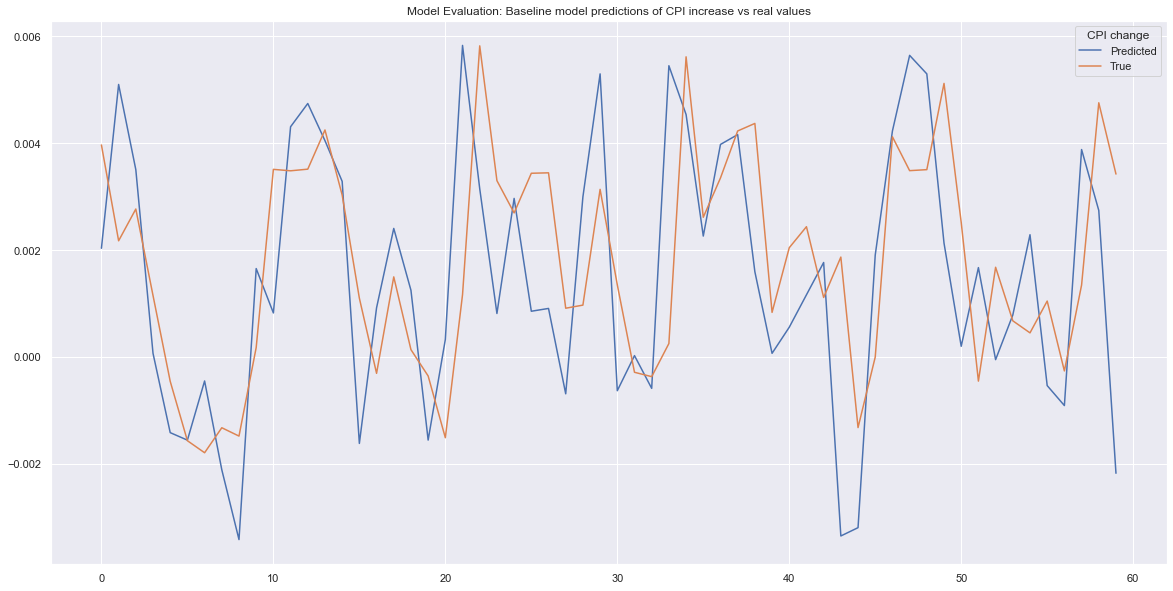

In [81]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred_linreg)
plt.legend(labels=["Predicted","True"], title = "CPI change")
plt.title('Model Evaluation: Baseline model predictions of CPI increase vs real values')
plt.show()

<AxesSubplot:>

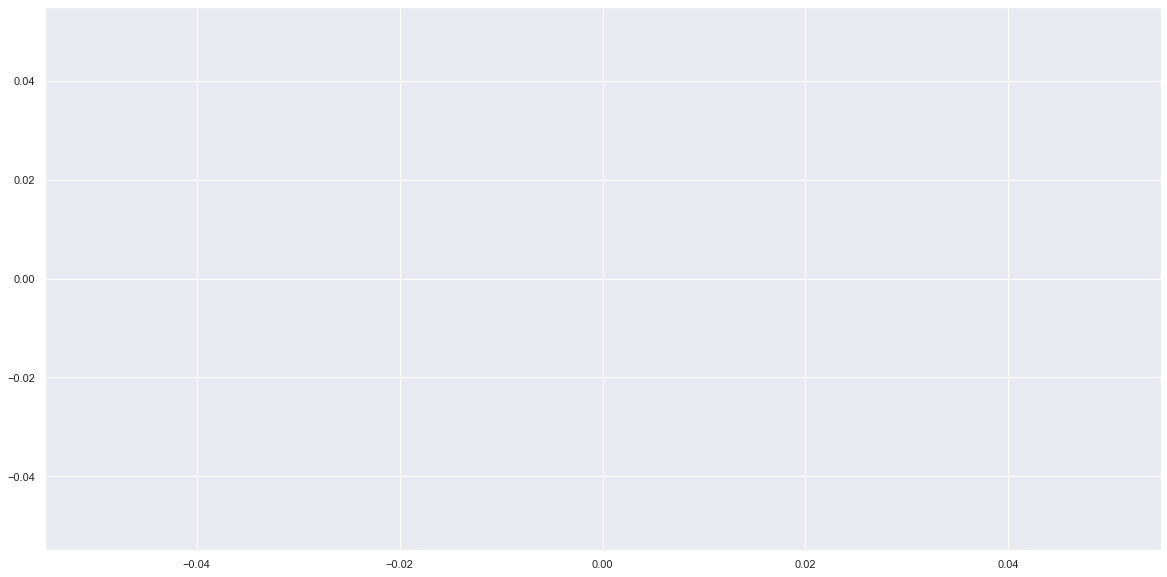

In [82]:
#sns.lineplot(y_test)
sns.lineplot(y_pred_linreg)

### CatBoost

In [83]:
model_catboost = CatBoostRegressor()

In [84]:
model_catboost.fit(X_train, y_train)

Learning rate set to 0.038184
0:	learn: 0.0035740	total: 151ms	remaining: 2m 30s
1:	learn: 0.0035375	total: 152ms	remaining: 1m 15s
2:	learn: 0.0034910	total: 153ms	remaining: 50.8s
3:	learn: 0.0034507	total: 154ms	remaining: 38.4s
4:	learn: 0.0034134	total: 155ms	remaining: 30.9s
5:	learn: 0.0033805	total: 156ms	remaining: 25.9s
6:	learn: 0.0033441	total: 157ms	remaining: 22.3s
7:	learn: 0.0033113	total: 159ms	remaining: 19.7s
8:	learn: 0.0032752	total: 160ms	remaining: 17.6s
9:	learn: 0.0032489	total: 161ms	remaining: 15.9s
10:	learn: 0.0032175	total: 162ms	remaining: 14.6s
11:	learn: 0.0031895	total: 163ms	remaining: 13.4s
12:	learn: 0.0031616	total: 164ms	remaining: 12.5s
13:	learn: 0.0031398	total: 165ms	remaining: 11.6s
14:	learn: 0.0031189	total: 167ms	remaining: 10.9s
15:	learn: 0.0030931	total: 168ms	remaining: 10.3s
16:	learn: 0.0030701	total: 169ms	remaining: 9.76s
17:	learn: 0.0030450	total: 170ms	remaining: 9.27s
18:	learn: 0.0030216	total: 171ms	remaining: 8.84s
19:	learn

161:	learn: 0.0019043	total: 338ms	remaining: 1.75s
162:	learn: 0.0019020	total: 339ms	remaining: 1.74s
163:	learn: 0.0018995	total: 340ms	remaining: 1.74s
164:	learn: 0.0018967	total: 342ms	remaining: 1.73s
165:	learn: 0.0018950	total: 344ms	remaining: 1.73s
166:	learn: 0.0018911	total: 345ms	remaining: 1.72s
167:	learn: 0.0018864	total: 347ms	remaining: 1.72s
168:	learn: 0.0018826	total: 349ms	remaining: 1.71s
169:	learn: 0.0018780	total: 350ms	remaining: 1.71s
170:	learn: 0.0018749	total: 352ms	remaining: 1.71s
171:	learn: 0.0018713	total: 354ms	remaining: 1.7s
172:	learn: 0.0018678	total: 355ms	remaining: 1.7s
173:	learn: 0.0018657	total: 357ms	remaining: 1.7s
174:	learn: 0.0018604	total: 359ms	remaining: 1.69s
175:	learn: 0.0018584	total: 361ms	remaining: 1.69s
176:	learn: 0.0018571	total: 362ms	remaining: 1.68s
177:	learn: 0.0018554	total: 364ms	remaining: 1.68s
178:	learn: 0.0018531	total: 366ms	remaining: 1.68s
179:	learn: 0.0018495	total: 368ms	remaining: 1.67s
180:	learn: 0.0

440:	learn: 0.0012543	total: 669ms	remaining: 848ms
441:	learn: 0.0012509	total: 670ms	remaining: 846ms
442:	learn: 0.0012504	total: 671ms	remaining: 844ms
443:	learn: 0.0012478	total: 672ms	remaining: 842ms
444:	learn: 0.0012473	total: 673ms	remaining: 840ms
445:	learn: 0.0012455	total: 674ms	remaining: 838ms
446:	learn: 0.0012421	total: 676ms	remaining: 836ms
447:	learn: 0.0012407	total: 677ms	remaining: 834ms
448:	learn: 0.0012373	total: 678ms	remaining: 832ms
449:	learn: 0.0012347	total: 679ms	remaining: 830ms
450:	learn: 0.0012328	total: 680ms	remaining: 828ms
451:	learn: 0.0012301	total: 681ms	remaining: 826ms
452:	learn: 0.0012296	total: 683ms	remaining: 824ms
453:	learn: 0.0012294	total: 684ms	remaining: 822ms
454:	learn: 0.0012284	total: 685ms	remaining: 820ms
455:	learn: 0.0012253	total: 686ms	remaining: 818ms
456:	learn: 0.0012251	total: 687ms	remaining: 817ms
457:	learn: 0.0012234	total: 688ms	remaining: 815ms
458:	learn: 0.0012219	total: 689ms	remaining: 813ms
459:	learn: 

731:	learn: 0.0008066	total: 1s	remaining: 366ms
732:	learn: 0.0008054	total: 1s	remaining: 365ms
733:	learn: 0.0008038	total: 1s	remaining: 363ms
734:	learn: 0.0008015	total: 1s	remaining: 362ms
735:	learn: 0.0007995	total: 1s	remaining: 361ms
736:	learn: 0.0007989	total: 1.01s	remaining: 359ms
737:	learn: 0.0007983	total: 1.01s	remaining: 358ms
738:	learn: 0.0007971	total: 1.01s	remaining: 356ms
739:	learn: 0.0007954	total: 1.01s	remaining: 355ms
740:	learn: 0.0007943	total: 1.01s	remaining: 353ms
741:	learn: 0.0007942	total: 1.01s	remaining: 352ms
742:	learn: 0.0007927	total: 1.01s	remaining: 350ms
743:	learn: 0.0007912	total: 1.01s	remaining: 349ms
744:	learn: 0.0007901	total: 1.01s	remaining: 348ms
745:	learn: 0.0007894	total: 1.02s	remaining: 346ms
746:	learn: 0.0007884	total: 1.02s	remaining: 345ms
747:	learn: 0.0007871	total: 1.02s	remaining: 343ms
748:	learn: 0.0007863	total: 1.02s	remaining: 342ms
749:	learn: 0.0007857	total: 1.02s	remaining: 340ms
750:	learn: 0.0007843	total

In [85]:
model_catboost.score(X_test, y_test)

0.5024713273338258

In [86]:
y_pred_catboost = model_catboost.predict(X_test)

In [87]:
print('Baseline results:')
print('-----------------')
print('RMSE: {:.2%}'.format(mean_squared_error(y_pred_catboost, y_test, squared=False)))

Baseline results:
-----------------
RMSE: 0.17%


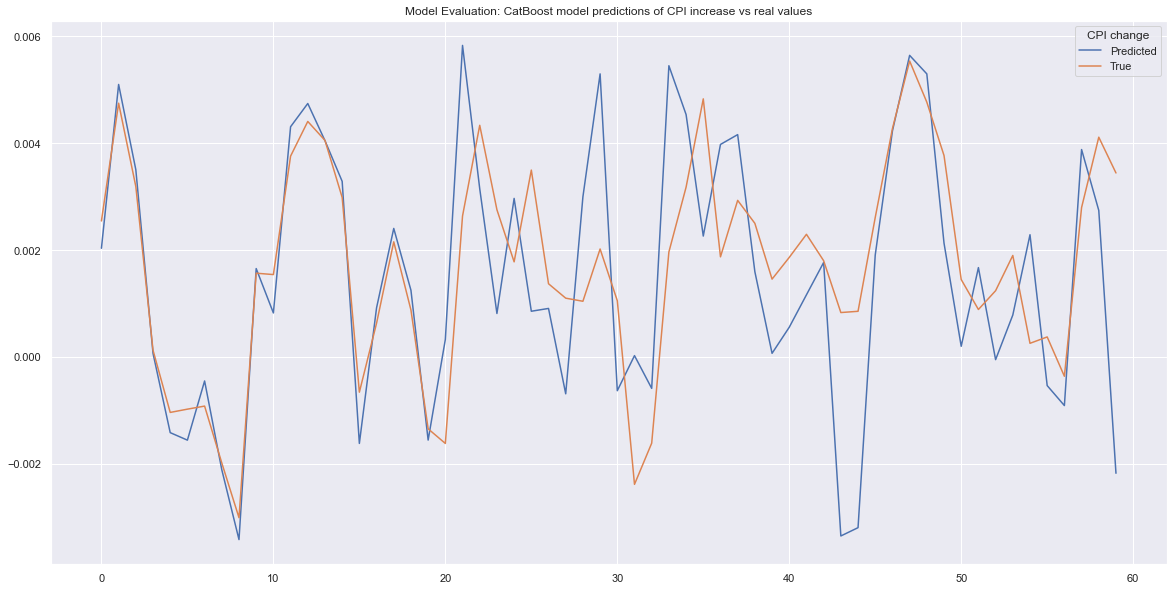

In [88]:
plt.plot(y_test.reset_index(drop=True))
plt.plot(y_pred_catboost)
plt.legend(labels=["Predicted","True"], title = "CPI change")
plt.title('Model Evaluation: CatBoost model predictions of CPI increase vs real values')
plt.show()